# DR9 GMMs

The goal of this notebook is to generate Gaussian mixture models (GMMs) from DR9 photometry for ELG, LRG, BGS, and QSO targets, and to incorporate morphologies and morphological types for ELG, LRG, and BGS targets.

There are also some diagnostic plots of the morphological fraction of each type of object as a function of apparent magnitude.

John Moustakas  
Siena College  
2022 January

In [1]:
import os, pdb
import warnings
import numpy as np
from pkg_resources import resource_filename

In [2]:
import fitsio
from astropy.table import Table, Column
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split

In [3]:
from desiutil.sklearn import GaussianMixtureModel
from desitarget.targetmask import desi_mask

In [4]:
import matplotlib.pyplot as plt
import corner as cn

In [5]:
import seaborn as sns
rc = {'font.family': 'serif'}#, 'text.usetex': True}

In [6]:
%matplotlib inline

#### Simulation variables

In [7]:
dr = 'dr9'
seed = 1
rand = np.random.RandomState(seed)
overwrite = True

### Read the reference target catalog.

In [8]:
def read_targets(dr='dr9', nsample=None, ndark=1, nbright=1):
    from glob import glob
    
    if dr == 'dr9':
        ver = '1.1.1'
        
    targetdir = os.path.join(os.getenv('DESI_ROOT'), 'target', 'catalogs', dr, 
                             ver, 'targets', 'main', 'resolve')
    darkfiles = glob(os.path.join(targetdir, 'dark', 'targets-dark-hp-*.fits'))
    brightfiles = glob(os.path.join(targetdir, 'bright', 'targets-bright-hp-*.fits'))
    
    darkfiles = rand.choice(darkfiles, size=ndark, replace=False)
    brightfiles = rand.choice(brightfiles, size=nbright, replace=False)
    targetfiles = np.hstack((darkfiles, brightfiles))

    targets = []
    for targetfile in targetfiles:
        if nsample:
            info = fitsio.FITS(targetfile)
            nrows = info[1].get_nrows()
            if nsample > nrows:
                these = None
            else:
                these = rand.choice(nrows, size=nsample, replace=False)
            _targets = fitsio.read(targetfile, rows=these)
        else:
            _targets = fitsio.read(targetfile)
            nsample = len(_targets)
        nrows = len(_targets)
        print('Read {} / {} objects from {}'.format(nsample, nrows, targetfile))
        targets.append(_targets)
        
    targets = Table(np.hstack(targets))
        
    return targets

In [ ]:
%time targets = read_targets(dr=dr, ndark=10, nbright=10, nsample=20000)
print('Reading {} targets'.format(len(targets)))

In [10]:
print(targets.colnames)

['RELEASE', 'BRICKID', 'BRICKNAME', 'BRICK_OBJID', 'MORPHTYPE', 'RA', 'RA_IVAR', 'DEC', 'DEC_IVAR', 'DCHISQ', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 'REF_EPOCH', 'WISEMASK_W1', 'WISEMASK_W2', 'MASKBITS', 'LC_FLUX_W1', 'LC_FLUX_W2', 'LC_FLUX_IVAR_W1', 'LC_FLUX_IVAR_W2', 'LC_NOBS_W1', 'LC_NOBS_W2', 'LC_MJD_W1', 'LC_MJD_W

### Some basic QA.

In [11]:
def qa_bic(ncomp, bic, title='Object', png=None):
    ncompbest = ncomp[np.argmin(bic)]
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(ncomp, bic / 100, marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion / 100')
    ax.set_title('{}: NGauss = {:d}'.format(title, ncompbest))
    if png:
        plt.savefig(png)

In [12]:
def qa_corner(Xdata, Xsample, labels, target='ELG', morph='DEV'):
    fig = cn.corner(Xdata, labels=labels, label_kwargs={'fontsize': 14}, 
                    show_titles=True, title_kwargs={'fontsize': 12},
                    color='k', quiet=True, hist2d_kwargs={'quiet': True},)
    fig.suptitle('{}/{}s Training Sample={} (grayscale), GMM Samples={} (green points)'.format(
        target, morph.strip(), Xdata.shape[0], Xsample.shape[0]))
    
    nobj, ndim = Xdata.shape
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.scatter(Xsample[:, xi], Xsample[:, yi], marker='s', 
                       color='g', s=5, alpha=0.5)
    if ndim > 3:
        fig.subplots_adjust(top=0.88)

### Wrapper functions for the Gaussian mixture modeling.

In [13]:
def get_data(target='ELG', morph='EXP', Nmax=None, maghist=False):
    """Build the data matrix."""
    from desitarget.targetmask import desi_mask, mws_mask, bgs_mask
    
    if 'BGS' in target:
        indx_targ = (targets['DESI_TARGET'] & desi_mask.BGS_ANY) != 0
    else:
        indx_targ = (targets['DESI_TARGET'] & desi_mask.mask(target.strip())) != 0
        
    indx_targ *= ( (targets['MASKBITS'] == 0) *
                   (targets['NOBS_G'] > 2) *
                   (targets['NOBS_R'] > 2) *
                   (targets['NOBS_Z'] > 2) *
                   (targets['FIBERFLUX_G'] > 0) *
                   (targets['FIBERFLUX_R'] > 0) *
                   (targets['FIBERFLUX_Z'] > 0) *
                   (targets['FLUX_G'] * np.sqrt(targets['FLUX_IVAR_G']) > 1) * 
                   (targets['FLUX_R'] * np.sqrt(targets['FLUX_IVAR_R']) > 1) * 
                   (targets['FLUX_Z'] * np.sqrt(targets['FLUX_IVAR_Z']) > 1) )

    with np.errstate(all='ignore'):
        # Soft cuts on grz S/N and shape measurements.
        indx_flux = (targets['MORPHTYPE'] == morph)
        indx_rad = ((targets['SHAPE_R'] * np.sqrt(targets['SHAPE_R_IVAR'])) > 1 ) * (targets['SHAPE_R'] < 10)
        indx_shape = ( ((targets['SHAPE_E1'] * np.sqrt(targets['SHAPE_E1_IVAR'])) > 1) *
                       ((targets['SHAPE_E2'] * np.sqrt(targets['SHAPE_E2_IVAR'])) > 1) )

        # When studying the morphological fractions, don't apply any S/N cuts on 
        # shapes and sizes.
        if maghist:
            indx = indx_targ
        
        if morph == 'PSF':
            indx = indx_targ * indx_flux
        elif morph == 'REX':
            indx = indx_targ * indx_flux * indx_rad
        else:
            indx = indx_targ * indx_flux * indx_rad * indx_shape

        nobj = np.count_nonzero(indx)
        #print('Selected {} {}s with morph={}'.format(nobj, target, morph))
        if nobj == 0:
            if maghist:
                return []
            else:
                return np.array([]), [], []
    
        gmag = 22.5 - 2.5 * np.log10(targets['FLUX_G'][indx] / targets['MW_TRANSMISSION_G'][indx])
        rmag = 22.5 - 2.5 * np.log10(targets['FLUX_R'][indx] / targets['MW_TRANSMISSION_R'][indx])
        zmag = 22.5 - 2.5 * np.log10(targets['FLUX_Z'][indx] / targets['MW_TRANSMISSION_Z'][indx])
        W1mag = 22.5 - 2.5 * np.log10(targets['FLUX_W1'][indx] / targets['MW_TRANSMISSION_W1'][indx])
        W2mag = 22.5 - 2.5 * np.log10(targets['FLUX_W2'][indx] / targets['MW_TRANSMISSION_W2'][indx])

        gr = gmag - rmag
        rz = rmag - zmag
        zW1 = zmag - W1mag
        W1W2 = W1mag - W2mag

        gfibermag = 22.5 - 2.5 * np.log10(targets['FIBERFLUX_G'][indx] / targets['MW_TRANSMISSION_G'][indx])
        rfibermag = 22.5 - 2.5 * np.log10(targets['FIBERFLUX_R'][indx] / targets['MW_TRANSMISSION_R'][indx])
        zfibermag = 22.5 - 2.5 * np.log10(targets['FIBERFLUX_Z'][indx] / targets['MW_TRANSMISSION_Z'][indx])
        
        if maghist:
            if target == 'LRG':
                return zmag
            else:
                return rmag
        
    if target == 'LRG':
        X = np.vstack( (zmag, gr, rz, zW1) )
        magandcolors = ('z', 'g - r', 'r - z', 'z - W1',)
        typecolumns = ('z', 'gr', 'rz', 'zW1',)
    elif target == 'ELG':
        X = np.vstack( (gmag, gr, rz) )
        magandcolors = ('g', 'g - r', 'r - z',)
        typecolumns = ('g', 'gr', 'rz',)
    elif target == 'QSO':
        X = np.vstack( (rmag, gr, rz, zW1, W1W2) )
        magandcolors = ('r', 'g - r', 'r - z', 'z - W1', 'W1 - W2',)
        typecolumns = ('r', 'gr', 'rz', 'zW1', 'W1W2',)
    else:
        X = np.vstack( (rmag, gr, rz) )
        magandcolors = ('r', 'g - r', 'r - z',)
        typecolumns = ('r', 'gr', 'rz',)
    
    if morph != 'PSF':        
        reff = np.log10(targets['SHAPE_R'][indx])
        reff_snr = np.log10(targets['SHAPE_R'][indx] * np.sqrt(targets['SHAPE_R_IVAR'][indx]))
    
    if morph == 'PSF':
        labels = magandcolors
        columns = typecolumns
    elif morph == 'REX':
        X = np.vstack( (X, 
                        rex_reff, rex_reff_snr) )
        labels = magandcolors + (
                  r'$\log_{10}(r_{eff,rex}$ (arcsec)', r'$\log_{10}(S/N\ r_{eff,rex})$',)
        columns = typecolumns + ('reff_rex', 'snr_reff_rex',)
    else:
        e1 = targets['SHAPE_E1'][indx]
        e2 = targets['SHAPE_E2'][indx]
        e1_snr = np.log10(targets['SHAPE_E1_IVAR'][indx] * np.sqrt(targets['SHAPE_E1_IVAR'][indx]))
        e2_snr = np.log10(targets['SHAPE_E2'][indx] * np.sqrt(targets['SHAPE_E2_IVAR'][indx]))

        
        X = np.vstack( (X, 
                        reff, e1, e2, 
                        reff_snr, e1_snr, e2_snr) )
        labels = magandcolors + (
                  r'$\log_{10}(r_{eff}$ (arcsec)', r'$e_{1}$', r'$e_{2}$', 
                  r'$\log_{10}(S/N\ r_{eff})$', r'$\log_{10}(S/N\ e_{1})$', r'$\log_{10}(S/N\ e_{2})$',)
        columns = typecolumns + (
                   'reff', 'e1', 'e2', 
                   'snr_reff', 'snr_e1', 'snr_e2',)
        
    if Nmax is not None and Nmax <= nobj:
        these = rand.choice(nobj, size=Nmax, replace=False)
        X = X[:, these]
            
    return X.T, labels, columns

In [14]:
#rr, _, _ = get_data(target='LRG', morph='EXP')
#print(rr.shape)
#np.any(np.isnan(rr))

In [15]:
def get_mog_bic(X, ncomp, rand=None):
    """Compute the MoG and BIC for a range of Gaussian components."""
    mog = [GMM(n_components=nc, random_state=rand).fit(X) for nc in ncomp]
    bic = [_mog.bic(X) for _mog in mog]
    return mog, np.array(bic)

In [16]:
def build_gmm(X, ncompmin=1, ncompmax=5, target='', morph='',
              columns=None, rand=None, png=None, overwrite=False):
    """Find the optimal GMM."""
    from astropy.io import fits

    if rand is None:
        rand = np.random.RandomState()
    ncomp = np.arange(ncompmin, ncompmax+1)

    gmmfile = resource_filename( 'desitarget', 'mock/data/{}/gmm_{}_{}.fits'.format(
        dr, target.lower(), morph.strip().lower()) )
    os.makedirs(os.path.dirname(gmmfile), exist_ok=True)
    
    if ~os.path.isfile(gmmfile) or overwrite:
        #print('Generating a GMM for {}/{} with N={}-{} components from {} objects.'.format(
        #    target, morph.strip(), ncompmin, ncompmax, X.shape[0]))
        allmog, bic = get_mog_bic(X, ncomp, rand=rand)
        qa_bic(ncomp, bic, png=png, title='{}/{}s (N={})'.format(
            target, morph.strip(), X.shape[0]))
    
        print('Writing {}'.format(gmmfile))
        mog = allmog[np.argmin(bic)] # minimize the BIC
        GaussianMixtureModel.save(mog, gmmfile)
                    
        # Update the FITS header with the column names.
        if columns is not None: 
            with fits.open(gmmfile, 'update') as ff:
                ff[0].header['NCOL'] = len(columns)
                for ii, col in enumerate(columns):
                    ff[0].header['COL{:02d}'.format(ii)] = col.lower()
    
    # (Re)read the model to get a few more convenience methods.
    #print('Reading {}'.format(gmmfile))
    mog = GaussianMixtureModel.load(gmmfile)

    return mog

### Get the fraction of morphological type for each target type as a function of magnitude.

In [17]:
def maghist_bins(deltam=0.5, minmag=19, maxmag=24, target='ELG', binedges=False):
    """Magnitude bins."""
    if target.strip() == 'LRG':
        minmag, maxmag = 18.0, 21.0
    elif target.strip() == 'BGS':
        minmag, maxmag = 14.0, 20.0
    else:
        minmag, maxmag = 19.0, 24.0
        
    if binedges:
        bins = np.arange(minmag, maxmag, deltam) # bin left edges
    else:
        bins = np.arange(minmag, maxmag, deltam) + deltam / 2 # bin centers
        
    return bins

In [18]:
def maghist_type(data, target='ELG'):
    """Fraction of a given morphological types as a function of magnitude."""
    bins = maghist_bins(target=target, binedges=True)
    hist, _ = np.histogram( data, bins=len(bins), range=(bins.min(), bins.max()) )
    return hist

In [19]:
def qa_maghist(data, target='ELG'):
    """Simple QA plot."""
    fig, ax = plt.subplots(figsize=(8, 6))
    magbins = data['MAG']
    ls = iter(['-', '--', '-.', ':', '-'])
    marker = iter(['s', 'o', '^', 'D', 'p'])
    
    for morph in ('PSF', 'REX', 'EXP', 'DEV', 'SER'):
        if morph in data.colnames:
            good = data[morph] > 0
            ax.plot(magbins[good], data[morph][good], '{}{}'.format(next(ls), next(marker)),
                    label=morph, lw=2, markersize=10)#, ls=next(ls)
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Morphological Type Fraction')

    if target == 'LRG':
        ax.set_xlabel('$z$ (AB mag)')
    elif target == 'ELG':
        ax.set_xlabel('$g$ (AB mag)')
    else:
        ax.set_xlabel('$r$ (AB mag)')
    ax.text(0.1, 0.95, target, ha='left', va='top', 
            transform=ax.transAxes, fontsize=18)
    ax.legend(loc='upper right')

In [20]:
def maghist_normalize(maghist, target='ELG'):
    """Normalize the type fractions and write out."""
    morph = [mm.strip() for mm in maghist.keys()]
    typefrac = [maghist[mm] for mm in maghist.keys()]

    frac = np.vstack(typefrac).astype('f4')
    tot = np.sum(frac, axis=0)
    normfrac = np.zeros_like(frac)
    notzero = np.where( tot > 0 )[0]
    for ii in range(frac.shape[0]):
        normfrac[ii, notzero] = frac[ii, notzero] / tot[notzero]
    
    out = Table()
    #out.add_column(Column(name='MORPH', data=morph))
    out.add_column(Column(name='MAG', data=maghist_bins(target=target), dtype='f4'))
    for ii, mm in enumerate(morph):
        out.add_column(Column(name=mm, data=normfrac[ii, :], dtype='f4'))
                         
    return out

In [21]:
def get_maghist(target, Nmax=50000, overwrite=False):
    """Get the magnitude histogram of each morphological type."""
    maghist = dict()
    for morph in ('PSF', 'REX', 'EXP', 'DEV', 'SER'):
        X = get_data(target=target, morph=morph, Nmax=Nmax, maghist=True)
        if len(X) == 0:
            continue
        maghist[morph.strip()] = maghist_type(X, target=target)

    out = maghist_normalize(maghist, target=target)

    # Write out
    fracfile = resource_filename('desitarget', 'mock/data/{}/fractype_{}.fits'.format(
        dr, target.lower()))
    os.makedirs(os.path.dirname(fracfile), exist_ok=True)
    if ~os.path.isfile(fracfile) or overwrite:
        print('Writing {}'.format(fracfile))
        out.write(fracfile, overwrite=True)

    qa_maghist(out, target=target)
        
    return out

In [22]:
sns.set(style='ticks', font_scale=1.5, palette='Set2', rc=rc)

Writing /global/homes/i/ioannis/code/desihub/desitarget/py/desitarget/mock/data/dr9/fractype_qso.fits
Writing /global/homes/i/ioannis/code/desihub/desitarget/py/desitarget/mock/data/dr9/fractype_bgs.fits
Writing /global/homes/i/ioannis/code/desihub/desitarget/py/desitarget/mock/data/dr9/fractype_elg.fits
Writing /global/homes/i/ioannis/code/desihub/desitarget/py/desitarget/mock/data/dr9/fractype_lrg.fits


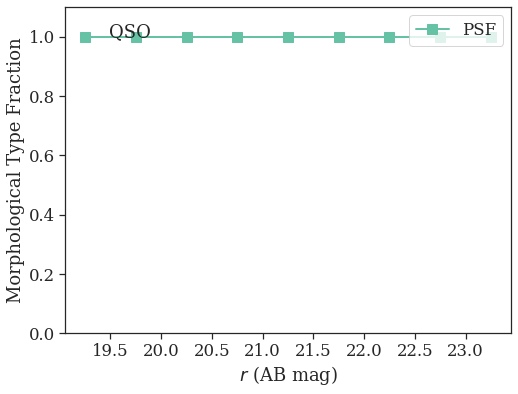

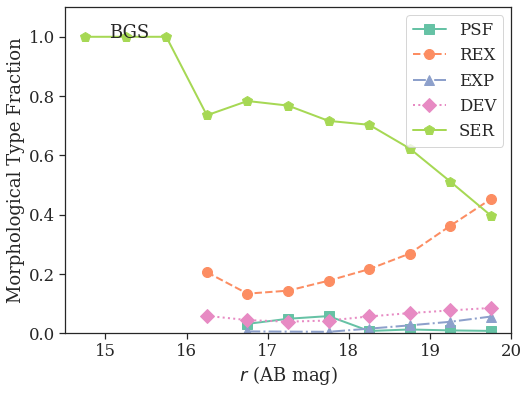

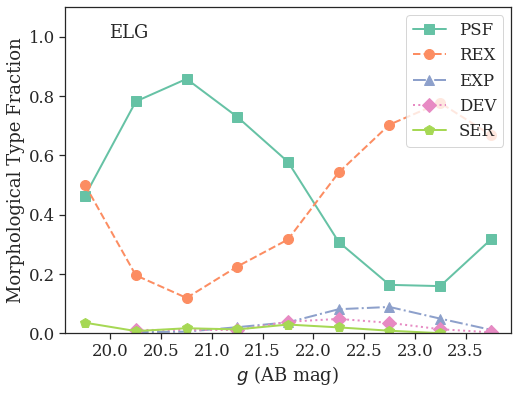

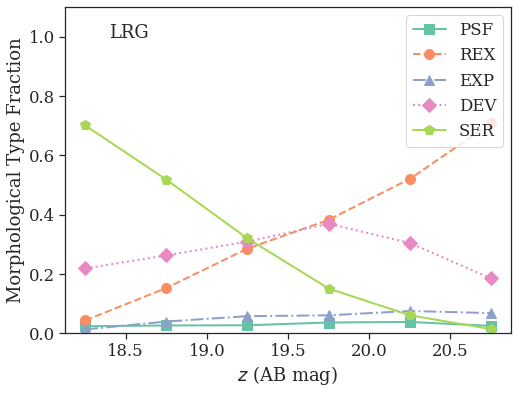

In [23]:
for target in ('QSO', 'BGS', 'ELG', 'LRG'):
    out = get_maghist(target, overwrite=overwrite)

### Now train and validate the GMMs for each combination of target and morphological type.

In [24]:
def train_and_validate(target, morph=None, Nmax=50000, Nsample=500, ncompmin=1, 
                       ncompmax=20, train_size=0.8, overwrite=False):
    
    test_size = 1-train_size
    if morph is None:
        morph = ('PSF', 'REX ', 'EXP', 'DEV', 'SER')
    
    for mm in np.atleast_1d(morph):
        X, labels, columns = get_data(target=target, morph=mm, Nmax=Nmax) # Nmax=20000)
        
        if X.shape[0] > 5*ncompmax:
            print('Training:testing {}:{} {}/{}s with {}-{} Gaussian components.'.format(
                np.round(X.shape[0]*train_size).astype('int'), np.round(X.shape[0]*test_size).astype('int'),
                target, mm.strip(), ncompmin, ncompmax))
        else:
            if X.shape[0] == 0:
                print('No  {}/{}s selected.'.format(target, mm))
            else:
                print('Only {} {}/{}s selected.'.format(X.shape[0], target, mm))
            continue

        Xtrain, Xvalidate = train_test_split(X, train_size=train_size, 
                                             test_size=1-train_size,
                                             random_state=rand)
    
        mog = build_gmm(Xtrain, ncompmin=ncompmin, ncompmax=ncompmax, 
                        overwrite=overwrite, target=target, morph=mm, 
                        rand=rand, columns=columns, png=None)
    
        Xsample = mog.sample(Nsample, random_state=rand)
        qa_corner(Xvalidate, Xsample, labels, target=target, morph=mm)
        
        print()

In [25]:
sns.reset_orig()
ncompmax = 15

### QSO

Training:testing 9394:2349 QSO/PSFs with 1-15 Gaussian components.
Writing /global/homes/i/ioannis/code/desihub/desitarget/py/desitarget/mock/data/dr9/gmm_qso_psf.fits

No  QSO/REX s selected.
No  QSO/EXPs selected.
No  QSO/DEVs selected.
No  QSO/SERs selected.
CPU times: user 7.89 s, sys: 155 ms, total: 8.04 s
Wall time: 8.07 s


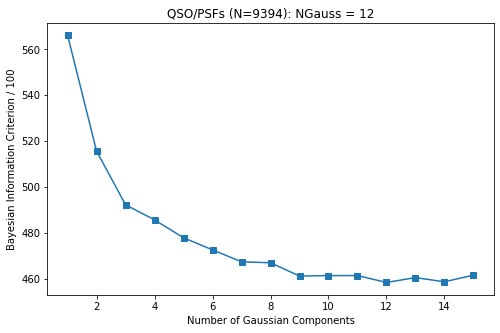

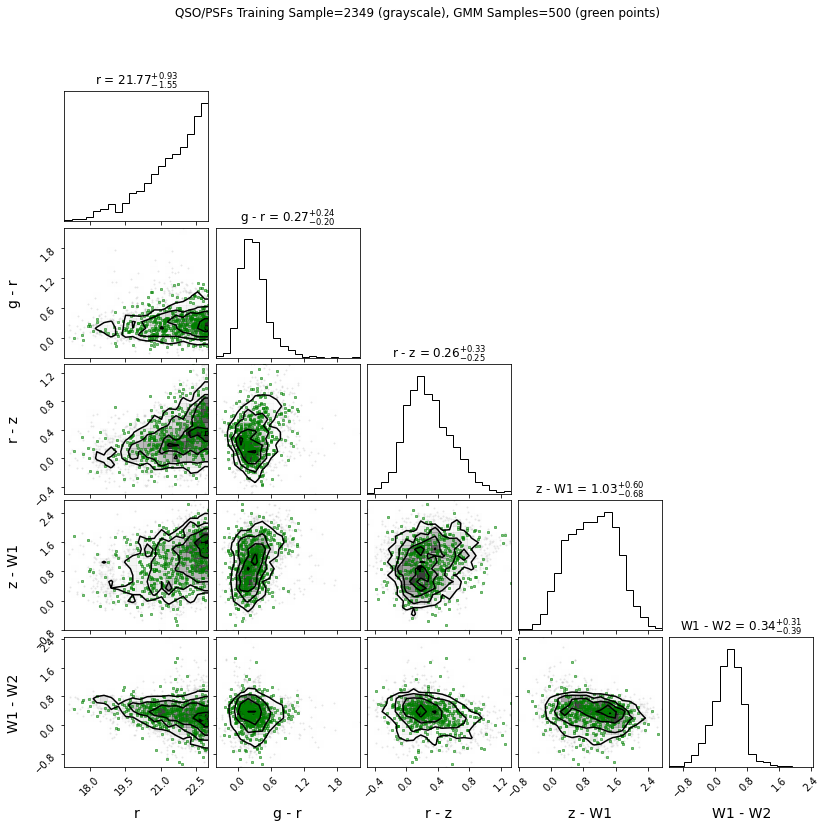

In [26]:
%time train_and_validate('QSO', Nsample=500, Nmax=None, ncompmax=ncompmax, overwrite=overwrite)

### LRG

Training:testing 319:80 LRG/PSFs with 1-15 Gaussian components.
Writing /global/homes/i/ioannis/code/desihub/desitarget/py/desitarget/mock/data/dr9/gmm_lrg_psf.fits

No  LRG/REX s selected.
Training:testing 366:91 LRG/EXPs with 1-15 Gaussian components.
Writing /global/homes/i/ioannis/code/desihub/desitarget/py/desitarget/mock/data/dr9/gmm_lrg_exp.fits

Training:testing 1450:362 LRG/DEVs with 1-15 Gaussian components.
Writing /global/homes/i/ioannis/code/desihub/desitarget/py/desitarget/mock/data/dr9/gmm_lrg_dev.fits

Training:testing 1170:292 LRG/SERs with 1-15 Gaussian components.
Writing /global/homes/i/ioannis/code/desihub/desitarget/py/desitarget/mock/data/dr9/gmm_lrg_ser.fits

CPU times: user 20.7 s, sys: 261 ms, total: 21 s
Wall time: 21.1 s


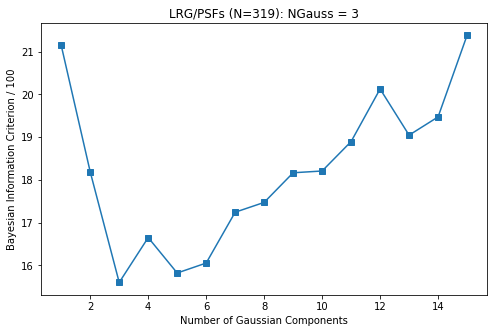

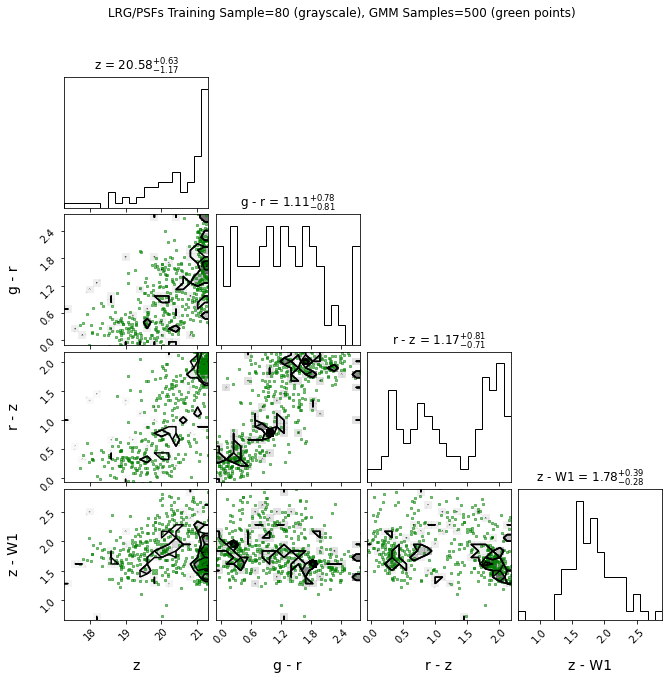

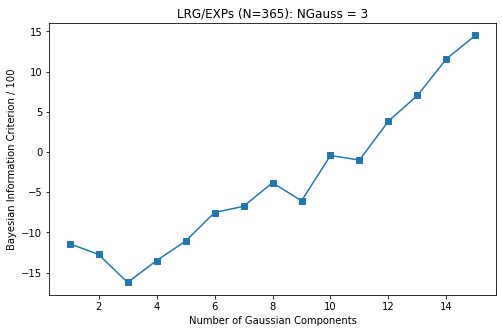

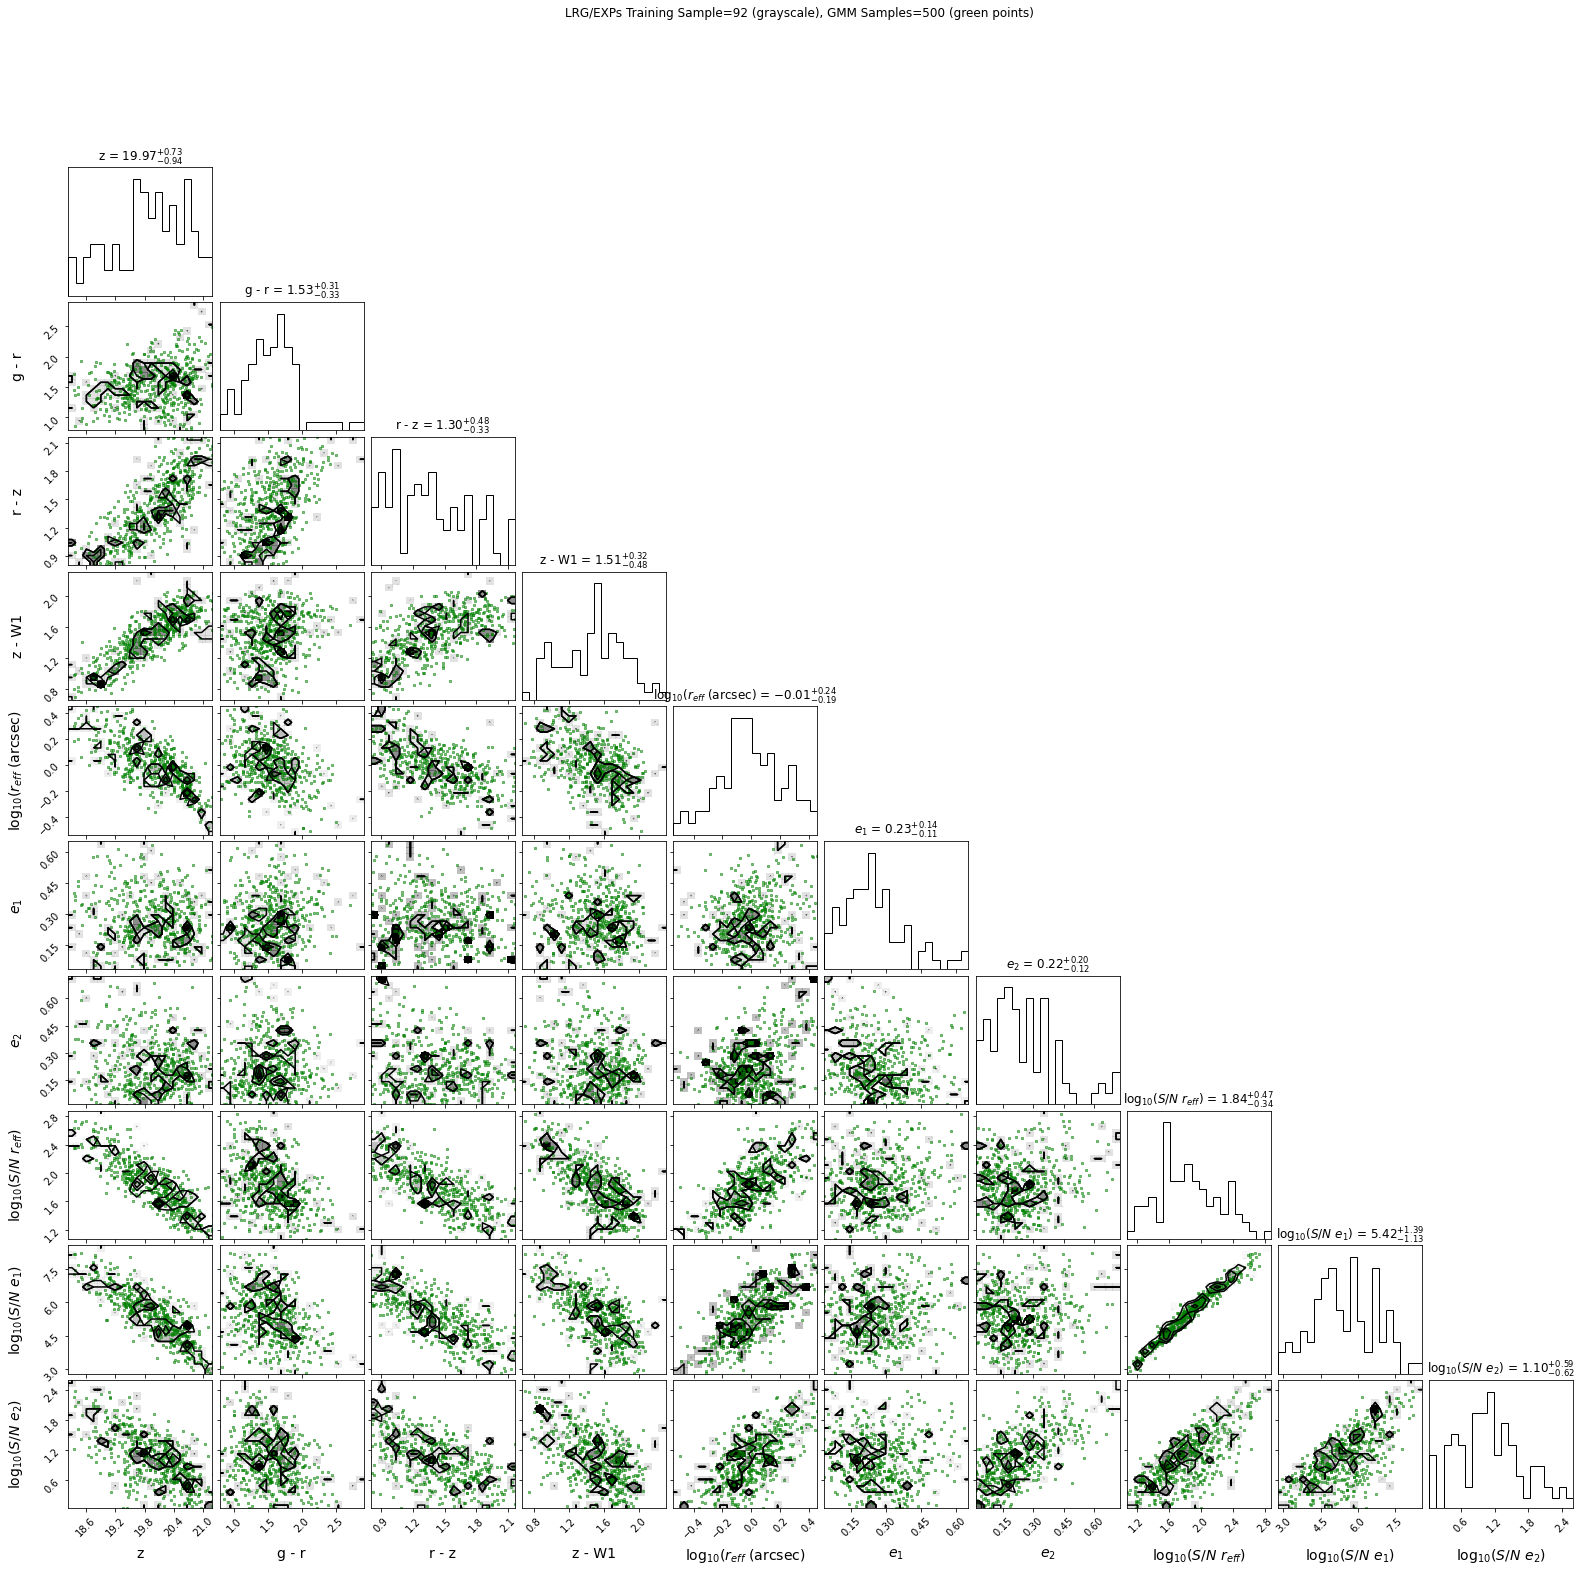

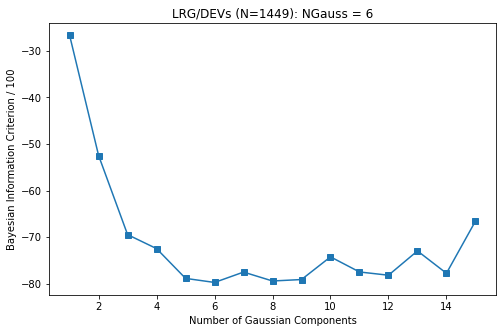

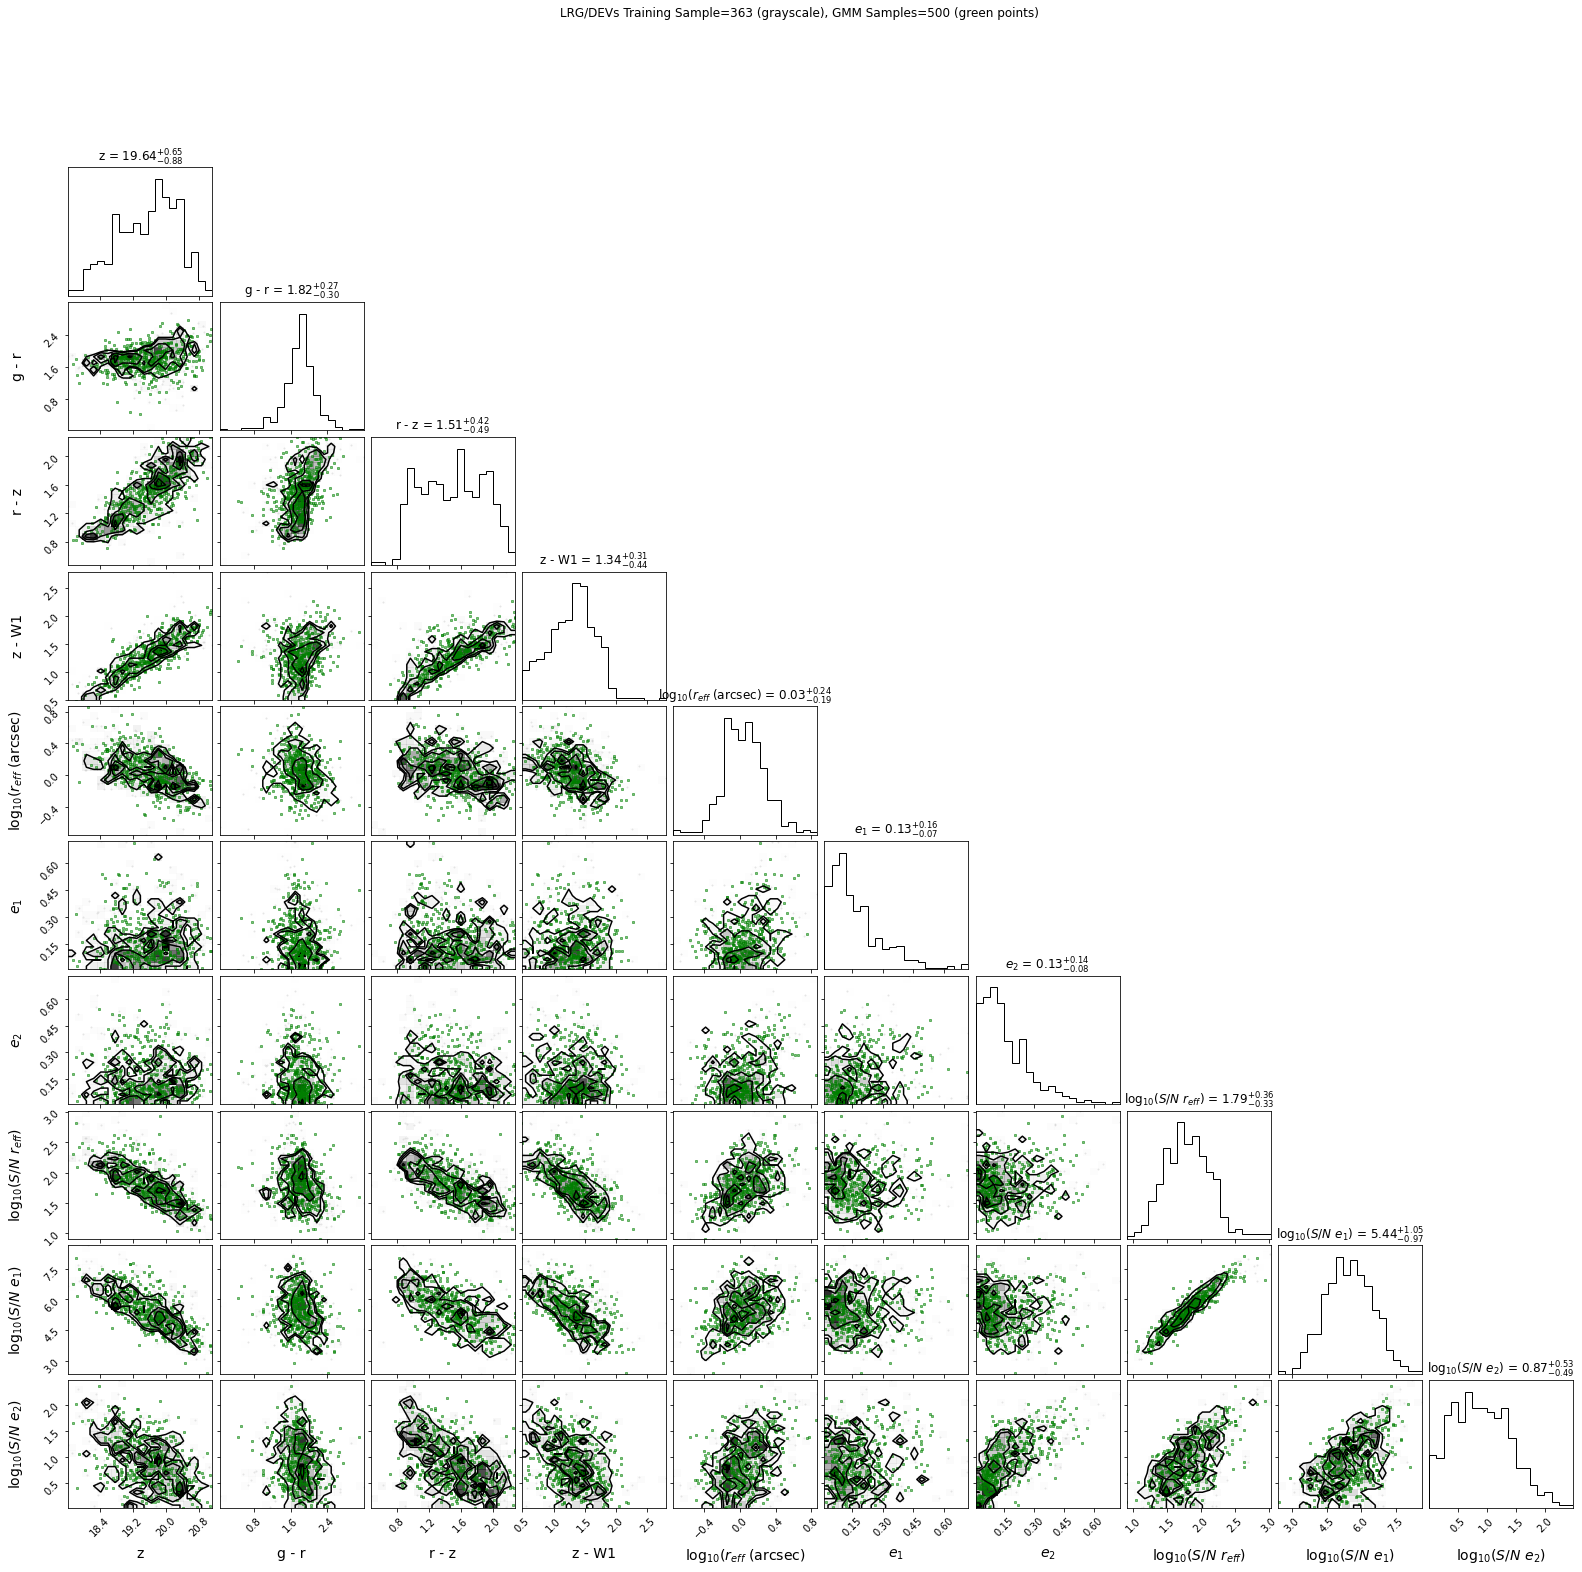

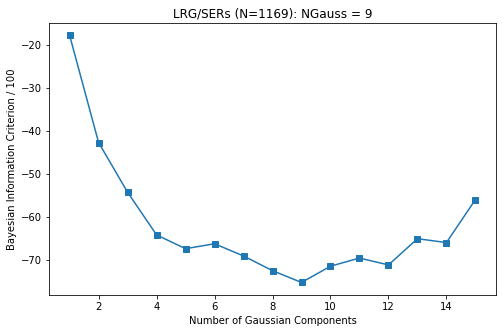

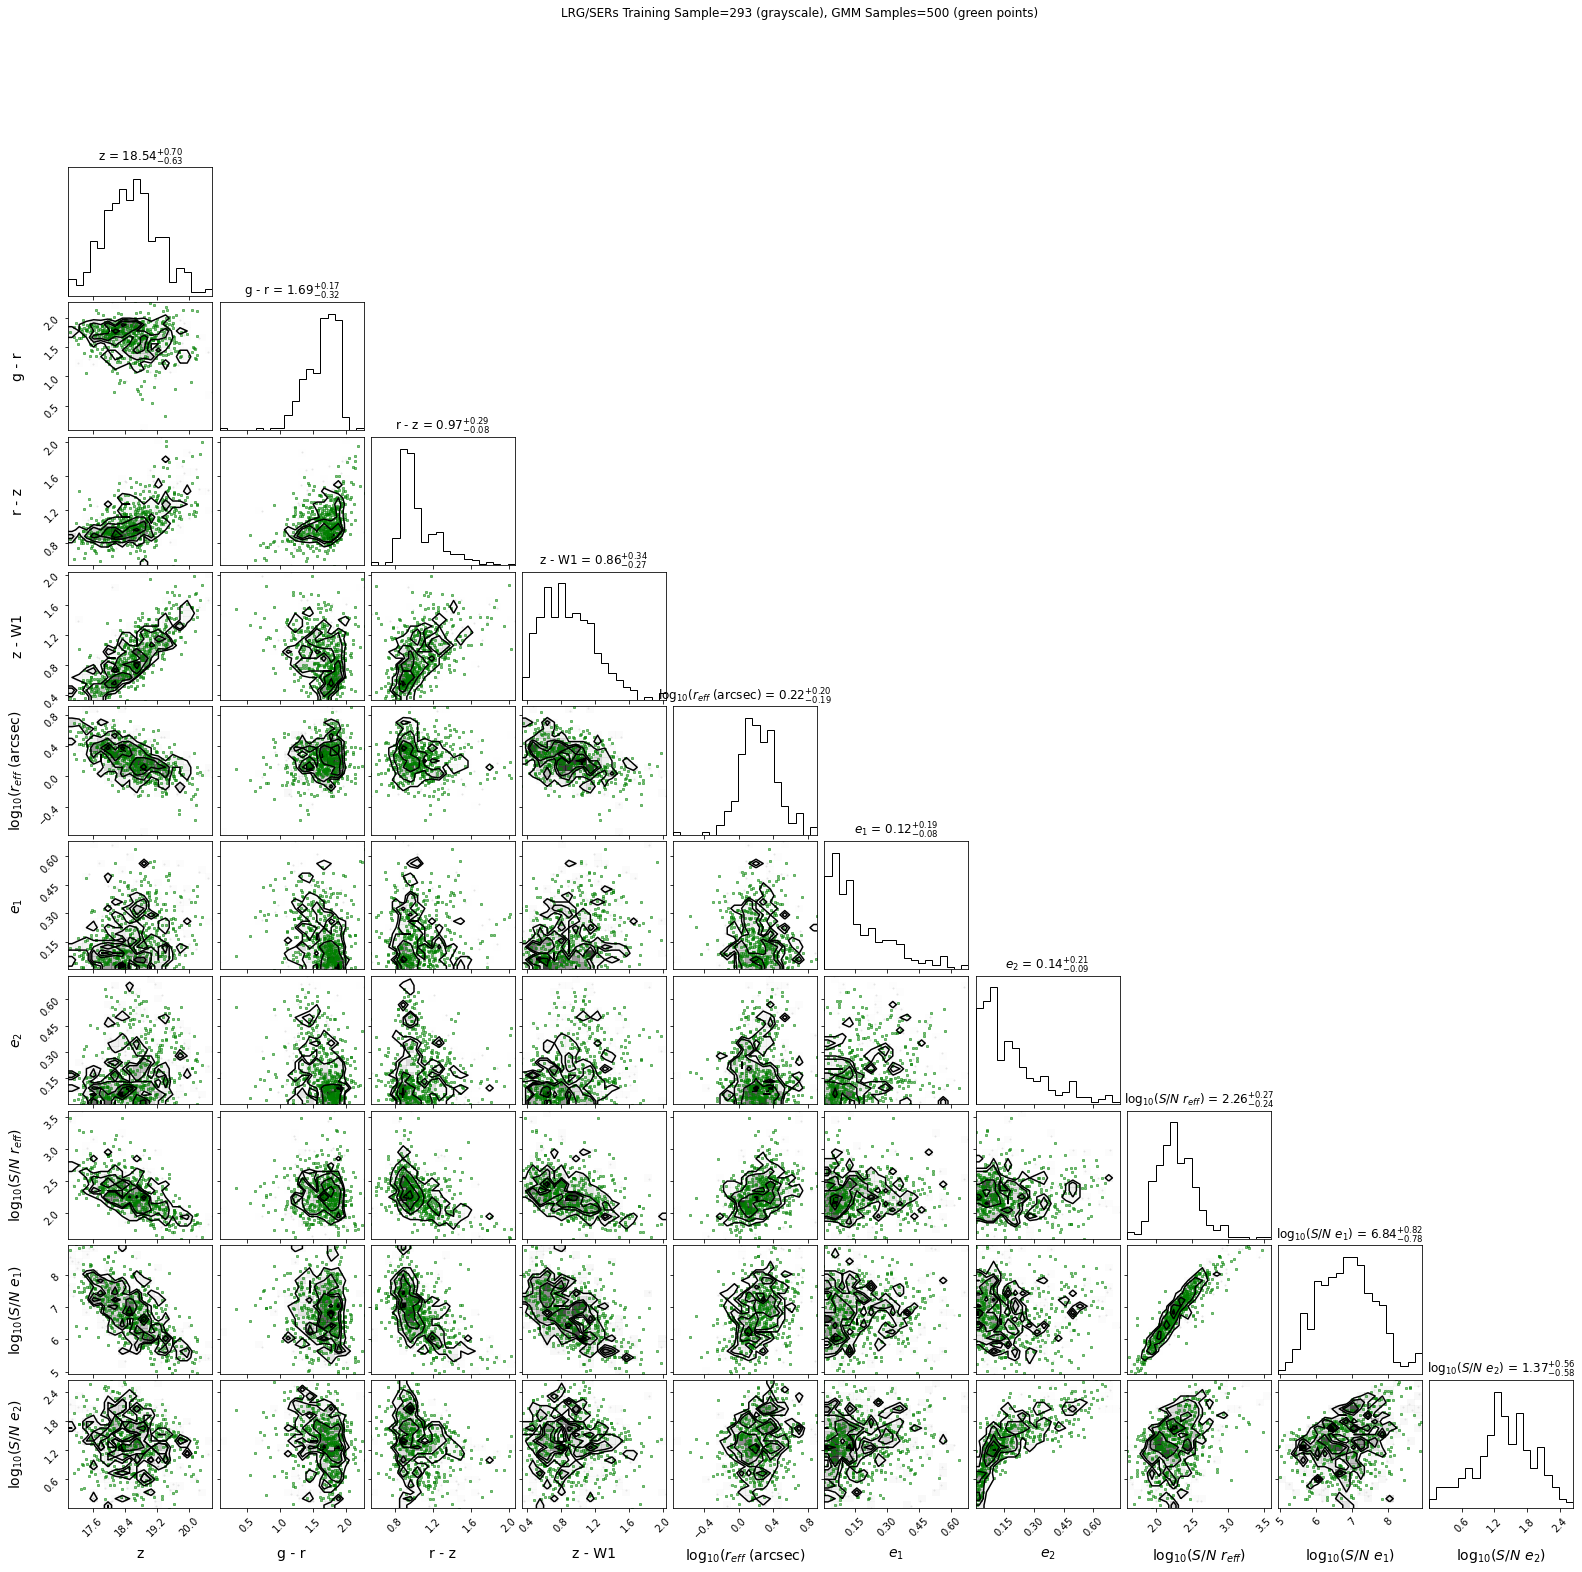

In [27]:
%time train_and_validate('LRG', Nsample=500, Nmax=None, ncompmax=ncompmax, overwrite=overwrite)

### ELG

In [ ]:
%time train_and_validate('ELG', Nsample=500, Nmax=None, ncompmax=ncompmax, overwrite=overwrite)

Training:testing 19598:4899 ELG/PSFs with 1-15 Gaussian components.
Writing /global/homes/i/ioannis/code/desihub/desitarget/py/desitarget/mock/data/dr9/gmm_elg_psf.fits

No  ELG/REX s selected.
Training:testing 1784:446 ELG/EXPs with 1-15 Gaussian components.
Writing /global/homes/i/ioannis/code/desihub/desitarget/py/desitarget/mock/data/dr9/gmm_elg_exp.fits


### BGS

In [ ]:
%time train_and_validate('BGS', Nsample=500, Nmax=None, ncompmax=ncompmax, overwrite=overwrite)